# GWSR Project

In [422]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import DirtCake as DC

## Soil Vapor Extraction

First we need to input the assumed parameters or given parameters

In [423]:
# assumed
R_well = 0.15 # [m]
R_inf = 7.5 # [m]
Pw = 0.9*101325 # [Pa]
temperature = 20 # C

# given
K = (2e-4 +1.8e-3)/2 # [m/s]
u_water = 8.891e-4 # [Ns/m^2]
g = 9.81 # [m/s^2]
den_water = 997 # [kg/m^3]
k = K*u_water/g/den_water # [m^2]
u_air = 2.096e-5 #



Next we need to obtain a dictionary of compound data. The formula to calculate vapour pressure at a temperature is log10(P) = A-(B/(T+C)) where T is in K and Pressure is in bar

In [424]:
def get_vap(A, B, C, T):
    logP = A-(B/(T+C))
    P_bar = 10**logP
    P_pa = P_bar*100000
    return P_pa

def get_KH(KH_i, T_i, T_f):
    return KH_i*1.048**(T_f-T_i)

In [425]:
comp_data = pd.read_csv('./params.csv')
comp_data.loc[2,'val'] = 101325
display(comp_data.head())

compound_dict = {}
for _, row in comp_data.iterrows():
    temp_dict = {}
    temp_dict['KH'] = get_KH(row.KH, row.KH_T_C, temperature)
    temp_dict['KD'] = row.KD
    temp_dict['molar'] = row.molar
    if np.isnan(row.val):
        temp_dict['P_vap'] = get_vap(row.A, row.B, row.C, temperature+273)
    else:
        temp_dict['P_vap'] = row.val
    compound_dict[row.Compound] = temp_dict


,Compound,molar,KH,KH_T_C,KD,A,B,C,val
0,vinyl chloride,62.498,0.501187,10,8.15,3.98598,892.757,-35.051,NaN
1,"1,2-dichloroethane",98.959,0.010000,10,12.95,4.58518,1521.789,-24.670,NaN
2,5-CAT,141.598,0.000081,25,48.90,NaN,NaN,NaN,101325.0
3,"cis-1,2-dichloroethene",96.943,0.079433,10,13.25,4.06900,1163.729,-47.174,NaN
4,trichlorethene,131.388,0.125893,10,20.45,3.55346,974.538,-85.811,NaN


Now to read the csv with all of the data for each stage and level

In [ ]:
sve = pd.read_csv('./SVE_data_part_2.csv')
sve.head()

In [427]:
row = sve.loc[1,sve.columns]
test = DC.DirtLayer(R_inf=R_inf, R_well=R_well, H=row.screen_length, depth = row.depth_bottom-row.depth_top, 
                    density=row.density, por=row.porosity, por_water=row.por_water, temp=temperature+273, k=k, u=u_air, 
                    Pw = Pw, intial_concs=row[17:-3].to_dict(), compound_data=compound_dict)

In [428]:
row[17:-3]

1,4-dichlorobenzene       2.890269
chlorobenzene             0.027055
vinyl chloride                 0.0
cis-1,2-dichloroethene    0.184242
trichlorethene            1.763465
Name: 1, dtype: object

In [429]:
data_collection = {}
for _, group in sve.groupby('stage'):
    levels = []
    stg = group.loc[group.index[0],'stage']
    for _, row in group.iterrows():
        obj = DC.DirtLayer(R_inf=R_inf, R_well=R_well, H=row.screen_length, depth = row.depth_bottom-row.depth_top, 
                    density=row.density, por=row.porosity, por_water=row.por_water, temp=temperature+273, k=k, u=u_air, 
                    Pw = Pw, intial_concs=row[16:-2].to_dict(), compound_data=compound_dict)
        obj.SVE(365*150, 1)
        levels.append([obj.results,obj.Q, obj.dt])
    data_collection[stg] = levels

now to find out when we beat the regulated values. The data collection is a dictionary holding stages that have a list and a flow rate, the list contains the levels for the stage and their results

In [430]:
reg_vals = np.array([0.15, 5000, 5000, 0.3, 7, 30, 0.5])
SF = 1.25

In [431]:
beat_times = []
compound_names = sve.columns[16:-2]

for stage, levels in tqdm(data_collection.items()):
    for (level, _,_), j in zip(levels,range(len(levels))):
        for i in range(len(reg_vals)):
            new_row = {}
            t = np.argwhere(level[1,i,:]<(reg_vals[i]/SF))
            idx = t[0][0] if len(t)>0 else -1
            if idx == 0:
                t_99 = np.argwhere(level[1,i,:]<0.1)
                idx_99 = t_99[0][0] if len(t_99) >0 else -2
            else:
                t_99 = -1
            new_row['stage'] = stage
            new_row['level'] = j
            new_row['time'] = idx
            #new_row['time_99'] = idx_99
            new_row['compound'] = compound_names[i]
            beat_times.append(new_row)


100%|██████████| 3/3 [00:00<00:00, 141.63it/s]


In [ ]:
df = pd.DataFrame(beat_times)
df.head()

In [434]:
data_collection[5][0][0][1,6,0]

2.312841066

## Activated Carbon 1

now we need to see how much flow rate we have to estimate the area needed. first we need to make dictionary with keys that lead to the number of wells for each stage

In [435]:
well_dict = {}

for idx, group in sve.groupby('stage'):
    well_dict[group.stage.values[0]] = group.wells.values[0]

In [436]:
flow_data =[]
for stage, item in data_collection.items():
    new_row ={}
    stage_well_flow = 0
    for [dataset, flow, dt] in item:
        stage_well_flow += flow
    new_row['stage'] = stage
    new_row['flow'] = stage_well_flow *well_dict[stage]
    new_row['dt'] = dt
    flow_data.append(new_row)

flow_df = pd.DataFrame(flow_data)
flow_df
    

,stage,flow,dt
0,2,57933.210250,1
1,4,142901.918617,1
2,5,262311.920477,1


In [437]:
total_Q = flow_df.flow.sum() # [m^3/day]
total_Q

463147.0493438188

assume a bed length of 6m and now that we have the total flow we can figure out a bed area that is required to acheive

In [438]:
bedL = 6 # [m]
v0 = 0.275*60*60*24 # [m/s] -> m/day
bed_area = total_Q/v0 # [m^3/day]/m*day -> [m^2]
bed_rad = np.ceil(10*(bed_area/np.pi)**0.5)/10
bed_rad

2.5

In [439]:
GAC_m = bedL*np.pi*bed_rad**2 *400 # 400 is bulk density of GAC from lecture slide 44
GAC_m # [kg]

47123.8898038469

now to find out how much contaminant each filter can hold if TCE is the main contaminant

In [440]:
Ka = 81076
nf_inv = 0.526
Kdes = 79.8
nfd_inv = 1
Ce = 2.3e-3/1000 # [mg/m^3]*[1m^3/1000l] -> [mg/l]

ad_ratio = Ka*Ce**nf_inv
des_ratio = Kdes*Ce**nfd_inv

gac_ratio_tce = ad_ratio-des_ratio #[mg/kg]

and what if chlorobenzene is the main contaminant

In [441]:
qs = 187.2 # [mg/g]
Kl = 27.88e-4 # [ppm^-1]
C_chloro = 50.05 *24.45/compound_dict['chlorobenzene']['molar'] # ug/m^3 -> ppm
gac_ratio_chloro = qs*Kl*C_chloro/(1+Kl*C_chloro)

In [442]:
print(gac_ratio_tce*GAC_m*0.75) # [mg/kg]*[kg]
print(gac_ratio_chloro*1000*GAC_m*0.75) # [mg/g]*[1000g/1kg]*[kg]

3100720.6555608464
194644896.82172328


for now we need to get the contaminant concentrations at each timestep to determine if our break through time makes sense. the order of axes is stage, contaminant, time

In [443]:
conc_arr = np.zeros((7,item[0][0].shape[1],item[0][0].shape[2]))
for stage, item in data_collection.items():
    conc_temp = np.zeros(item[0][0].shape[1:])
    for [dataset, flow, dt] in item:
        conc_temp += dataset[8,:,:]
    conc_temp*well_dict[stage]
    conc_arr[stage-1,:,:] = conc_temp

conc_arr[6,:,:] = conc_arr[:6,:,:].sum(axis=0)

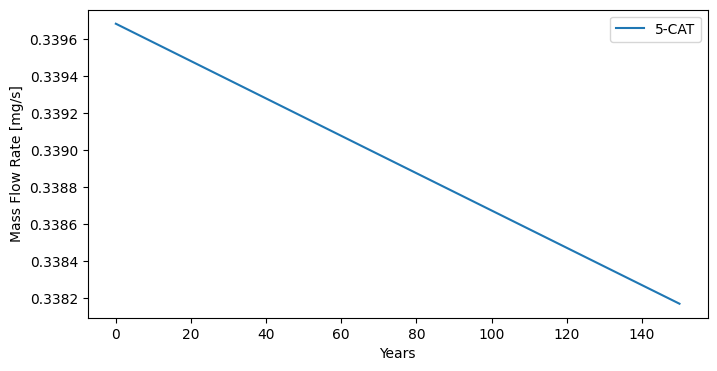

In [444]:
conc_arr_combined = conc_arr.sum(axis=0)
conc_arr_combined.shape
years = np.linspace(0,(conc_arr_combined.shape[1]-1)/365,conc_arr_combined.shape[1]-1)
plt.figure(figsize=(8,4))
# for i in range(conc_arr_combined.shape[0]):
#     plt.plot(years, conc_arr_combined[i,:-1]/3600/24, label=compound_names[i])

# plt.plot(years, conc_arr_combined[:,:-1].sum(axis=0)/3600/24, label='total', color='k')
plt.plot(years, conc_arr_combined[-1,:-1], label = compound_names[-1])
plt.xlabel('Years')
plt.ylabel('Mass Flow Rate [mg/s]')
plt.legend()
#conc_arr.sum(axis=0).sum(axis=0)

In [445]:
total_gas_flow = conc_arr_combined.sum(axis=0)
filter_data = []
gac_adsorp_chloro = gac_ratio_chloro*1000*GAC_m*0.75
gac_adsorp_tce = gac_ratio_tce*GAC_m*0.75
filter_mass = 0
for i in range(len(total_gas_flow)):
    if i<4*365:
        full = gac_adsorp_chloro
    else:
        full = gac_adsorp_tce
    
    filter_mass+=total_gas_flow[i]
    if filter_mass>full:
        filter_data.append(i-1)
        filter_mass=0

    
filter_data

[1459, 2998, 13932]

Time to export some data

In [446]:
mapper = {
    0:compound_names[0],
    1:compound_names[1],
    2:compound_names[2],
    3:compound_names[3],
    4:compound_names[4],
    5:compound_names[5],
    6:compound_names[6],

}
for stage, item in data_collection.items():
    stageframe = []
    for [dataset, flow, dt] in item:
        stageframe.append(pd.DataFrame(dataset[1,:,-1]).to_dict()[0])
    pd.DataFrame(stageframe).rename(columns=mapper).to_csv(f'./sve_3/{stage}.csv')